In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, RocCurveDisplay, \
    confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Source data

In [21]:
# review_file = '../data/res/prediction/train_epoch=4.csv'
# review_file = '../data/res/prediction/val_epoch=4.csv'
review_file = '../data/res/prediction/test.csv'

In [22]:
review_df = pd.read_csv(review_file, sep=',')
review_df.shape

(3074, 3)

In [23]:
review_df.head()

,Review,Rating,prediction
0,great place stay stay inn bourbon new orleans ...,4,4
1,excellent place stay nice hotel stay room big ...,4,4
2,great location service stay kid december 1920 ...,4,4
3,amaze amsterdam stayed hotel 14th 19th februar...,4,4
4,brief enjoyable add thumb regard hotel alessan...,3,4


In [24]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3074 entries, 0 to 3073
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review      3074 non-null   object
 1   Rating      3074 non-null   int64 
 2   prediction  3074 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 72.2+ KB


<AxesSubplot:xlabel='label'>

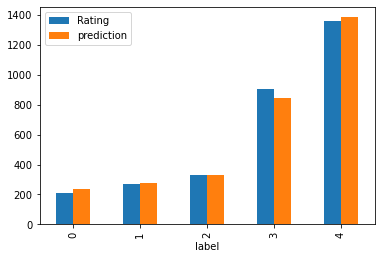

In [61]:
counts_df = review_df['Rating'].value_counts().sort_values().to_frame().reset_index()
pred_counts_df = review_df['prediction'].value_counts().sort_values().to_frame().reset_index()
counts_df = pd.merge(counts_df, pred_counts_df, how='left', on=['index'])
counts_df.rename(columns={'index': 'label'}, inplace=True)
counts_df.plot.bar(x='label', y=['Rating', 'prediction'])

In [27]:
labels = [0, 1, 2, 3, 4]

# Multilabel metrics

In [28]:
def multilabel_metrics(y_true, y_pred, labels):
    metrics_df = list()
    for l in labels:
        inds_true = np.where(y_true == l)
        # for accuracy
        y_true_l = y_true[inds_true]
        y_pred_l = y_pred[inds_true]
        # for precision, recall, f1
        y_true_bin_l = y_true == l
        y_pred_bin_l = y_pred == l
        # label metrics
        pr_l = precision_score(y_true_bin_l, y_pred_bin_l, average='binary')
        rec_l = recall_score(y_true_bin_l, y_pred_bin_l, average='binary')
        f1_l = f1_score(y_true_bin_l, y_pred_bin_l, average='binary')   
        acc_l = accuracy_score(y_true_l, y_pred_l)     
        metrics_df.append(
            pd.Series(
                data={
                    'label': l,
                    'precision': pr_l,
                    'recall': rec_l,
                    'f1': f1_l,
                    'accuracy': acc_l
                }
            )
        )           
    metrics_df = pd.concat(metrics_df, axis=1, ignore_index=True).transpose()
    metrics_df['label'] = metrics_df['label'].astype(np.int)
    metrics_df.sort_values(by='label', ascending=True, inplace=True)
    return metrics_df

In [29]:
multilabel_metrics_df = multilabel_metrics(review_df['Rating'].values, review_df['prediction'].values, labels=labels)
multilabel_metrics_df.shape

(5, 5)

In [30]:
multilabel_metrics_df.head()

,label,precision,recall,f1,accuracy
0,0,0.673640,0.755869,0.712389,0.755869
1,1,0.456835,0.472119,0.464351,0.472119
2,2,0.458967,0.460366,0.459665,0.460366
3,3,0.569905,0.530905,0.549714,0.530905
4,4,0.781792,0.796760,0.789205,0.796760


In [31]:
def plot_multilabel_metrics(metrics_df):
    for col in metrics_df.columns[1:]:
        metrics_df.plot.bar(x='label', y=col)        

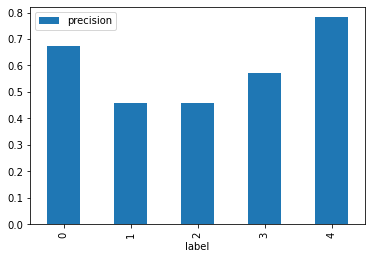

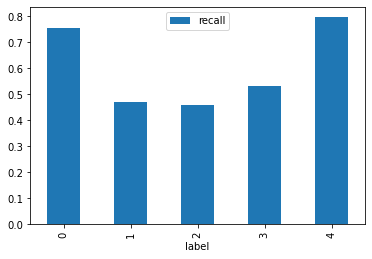

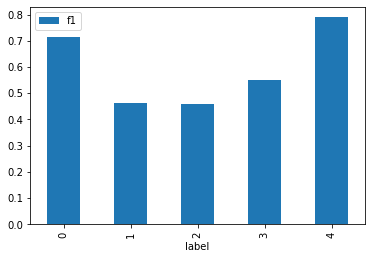

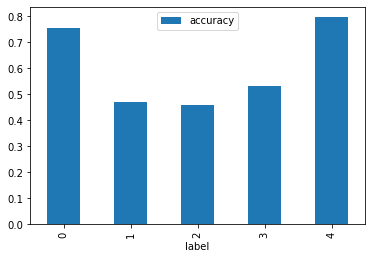

In [32]:
plot_multilabel_metrics(multilabel_metrics_df)

# ROC AUC

In [33]:
def plot_one_vs_rest_roc(y_true, y_pred, labels):
    fig, ax = plt.subplots(figsize=(7, 7))
    for l in labels:
        y_true_bin_l = y_true == l
        y_pred_bin_l = y_pred == l
        RocCurveDisplay.from_predictions(
            y_true_bin_l,
            y_pred_bin_l,
            name="ROC curve for label {}".format(l),
            ax=ax
        )
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multilabel")
    plt.legend()
    plt.show()

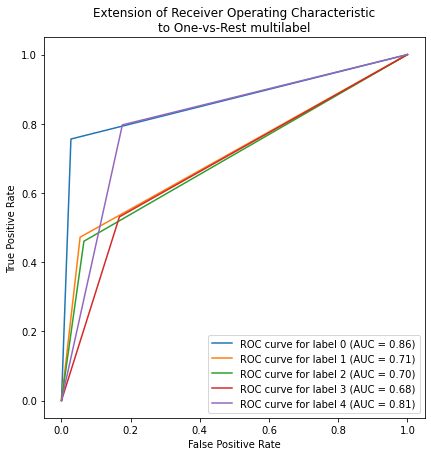

In [34]:
plot_one_vs_rest_roc(review_df['Rating'].values, review_df['prediction'].values, labels=labels)

# Confusion matrix

In [35]:
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    conf_matrix_display = ConfusionMatrixDisplay(
        conf_matrix,
        display_labels=np.sort(labels)
    )
    conf_matrix_display.plot()

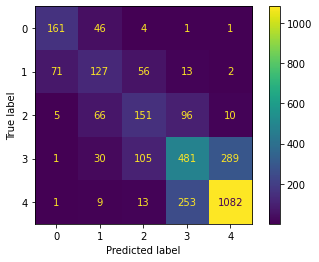

In [36]:
plot_confusion_matrix(review_df['Rating'].values, review_df['prediction'].values, labels=labels)

# Classification report

In [37]:
def get_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    return report_df

In [38]:
get_classification_report(review_df['Rating'].values, review_df['prediction'].values)

,precision,recall,f1-score,support
0,0.673640,0.755869,0.712389,213.000000
1,0.456835,0.472119,0.464351,269.000000
2,0.458967,0.460366,0.459665,328.000000
3,0.569905,0.530905,0.549714,906.000000
4,0.781792,0.796760,0.789205,1358.000000
accuracy,0.651269,0.651269,0.651269,0.651269
macro avg,0.588228,0.603204,0.595065,3074.000000
weighted avg,0.648966,0.651269,0.649708,3074.000000
